In [8]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2, edelbaum

# Main imports
import heyoka as hy
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import pandas as pd

# Usual imports
import time
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

# Jupyter setup
%matplotlib notebook
%load_ext autoreload
%autoreload 2  # Autoreload all modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and visualize the database
The file nominal.pk is created in the previous notebook (single shooting)

In [24]:
filename = 'nominal_all_value_function_learning'
with open(f"data/{filename}.pk", "rb") as file:
    db = pkl.load(file)
    
# Target orbit definition
r_target = db[0][1]
omega = np.sqrt(pk.MU_SUN / r_target**3)

#ND Units
TIME   = np.sqrt(pk.AU**3/pk.MU_SUN)
L = pk.AU
V = L/TIME

In [10]:
# We transform the dataset initial conditions into orbital elements and get the min tof
osc, tof, tof_edelbaum, ic, eq = [], [],[], [], []
for entry in db:
    cartesian = entry[0]
    r = cartesian[:3]
    v = cartesian[3:]
    # We move it to the inertial frame
    v[0] = v[0] - omega * r[1]
    v[1] = v[1] + omega * r[0]
    osculating = pk.ic2par(r,v,pk.MU_SUN)
    equinoctial = pk.ic2eq(r,v,pk.MU_SUN)
    tof.append(np.min(np.array(entry[-1])[:,-1]))
    tof_edelbaum.append(edelbaum(osculating[0], r_target, osculating[2])[1] / TIME)
    ic.append([r[0],r[1],r[2],v[0],v[1],v[2]])
    eq.append(equinoctial)
    osc.append(osculating)

osc = np.array(osc)
tof_edelbaum = np.array(tof_edelbaum)
tof = np.array(tof)
ic = np.array(ic)
eq = np.array(eq)

<IPython.core.display.Javascript object>


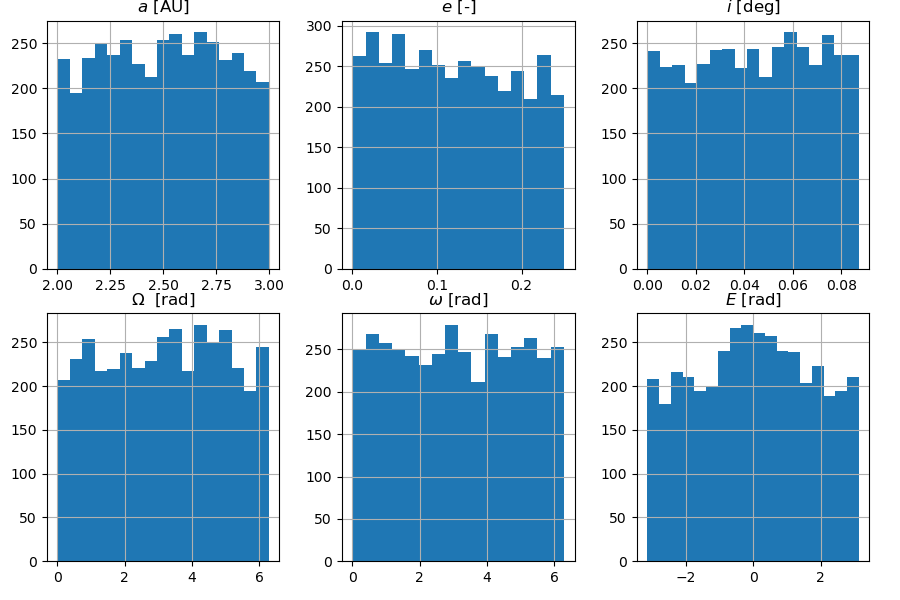

In [11]:
# Plot the orbital elements
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (9,6))
fig.tight_layout()

ax1.set_title('$a$ [AU]')
ax1.grid()
ax2.set_title('$e$ [-]')
ax2.grid()
ax3.set_title('$i$ [deg]')
ax3.grid()
ax4.set_title('$\Omega$  [rad]')
ax4.grid()
ax5.set_title('$\omega$ [rad]')
ax5.grid()
ax6.set_title('$E$ [rad]')
ax6.grid()

ax1.hist(osc[:,0] / pk.AU, bins='auto') 
ax2.hist(osc[:,1], bins='auto')
ax3.hist(osc[:,2], bins='auto')
ax4.hist(osc[:,3], bins='auto')
ax5.hist(osc[:,4], bins='auto')
ax6.hist(osc[:,5], bins='auto');

<IPython.core.display.Javascript object>


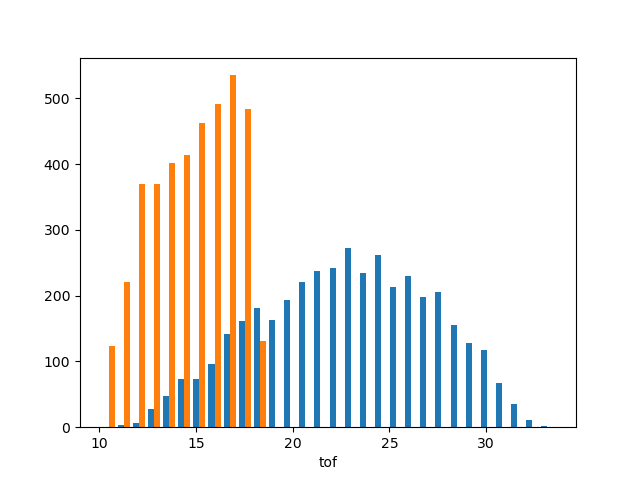

In [12]:
plt.figure()
plt.hist([tof, tof_edelbaum], bins=30);
plt.xlabel("tof");

<IPython.core.display.Javascript object>


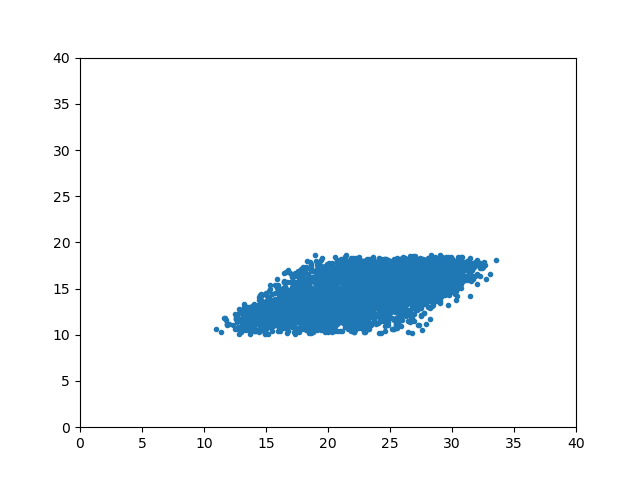

(0.0, 40.0)

In [13]:
plt.figure()
plt.plot(tof, tof_edelbaum, '.')
plt.xlim(0,40)
plt.ylim(0,40)

# We prepare the data for learning

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [15]:
attributes = np.hstack((eq, tof_edelbaum.reshape(-1,1)))
X_train, X_test, Y_train, Y_test = train_test_split(attributes, tof, random_state=1)
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train[:,:6])
X_train_minmax = min_max_scaler.transform(X_train[:,:6])
X_test_minmax = min_max_scaler.transform(X_test[:,:6])

In [16]:
nn_regr = MLPRegressor(random_state=123, 
                     max_iter=500, 
                     hidden_layer_sizes=(100, 100, 100, 100, 100), 
                     learning_rate = 'adaptive', 
                     batch_size=32, 
                     verbose=True,
                     warm_start = True,
                     activation = 'relu',
                     learning_rate_init=0.5*1e-3)

In [17]:
nn_regr.fit(X_train_minmax, Y_train) 

Iteration 1, loss = 104.08733657
Iteration 2, loss = 7.75465229
Iteration 3, loss = 6.68633918
Iteration 4, loss = 6.09821307
Iteration 5, loss = 5.68383679
Iteration 6, loss = 5.29907894
Iteration 7, loss = 5.09242126
Iteration 8, loss = 4.83044168
Iteration 9, loss = 4.56186030
Iteration 10, loss = 4.37995633
Iteration 11, loss = 3.98024716
Iteration 12, loss = 3.73963449
Iteration 13, loss = 3.41711922
Iteration 14, loss = 3.15546395
Iteration 15, loss = 2.98181942
Iteration 16, loss = 2.97346031
Iteration 17, loss = 2.65068514
Iteration 18, loss = 2.49607030
Iteration 19, loss = 2.26344005
Iteration 20, loss = 2.06482133
Iteration 21, loss = 1.97446608
Iteration 22, loss = 1.85197862
Iteration 23, loss = 1.69117465
Iteration 24, loss = 1.68029989
Iteration 25, loss = 1.53187166
Iteration 26, loss = 1.47209646
Iteration 27, loss = 1.40630316
Iteration 28, loss = 1.41358562
Iteration 29, loss = 1.33281526
Iteration 30, loss = 1.28581413
Iteration 31, loss = 1.35907986
Iteration 32, l

MLPRegressor(batch_size=32, hidden_layer_sizes=(100, 100, 100, 100, 100),
             learning_rate='adaptive', learning_rate_init=0.0005, max_iter=500,
             random_state=123, verbose=True, warm_start=True)

In [35]:
Rscore = nn_regr.score(X_test_minmax, Y_test)
predict = nn_regr.predict(X_test_minmax)
err_in_days = np.mean(np.abs(predict-Y_test))
print("R score: ", Rscore)
print("Error in days: ", err_in_days * TIME * pk.SEC2DAY)

with open("data/train_test_ml.pk", "wb") as file:
    pkl.dump((X_train, X_test, Y_train, Y_test), file)

R score:  0.919233269901977
Error in days:  35.05521287325735


<IPython.core.display.Javascript object>


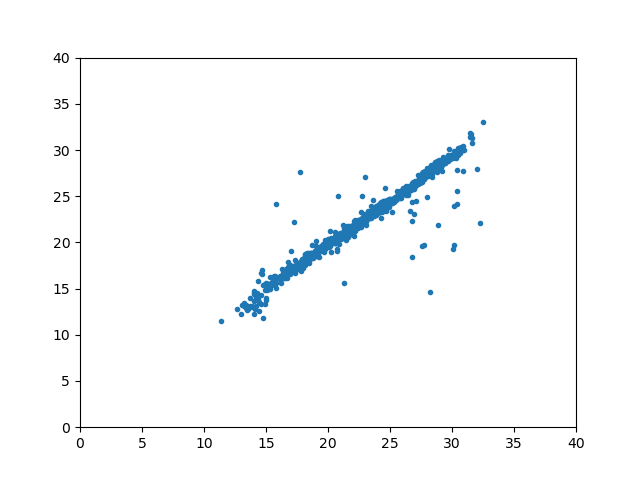

(0.0, 40.0)

In [36]:
plt.figure()
plt.plot(Y_test, predict, '.')

plt.xlim(0,40)
plt.ylim(0,40)

In [25]:
len(db)

4000

In [28]:
np.random.shuffle(db)

In [29]:
db[0]

[[-124767268237.51935,
  -304362156080.2752,
  4487697776.188225,
  -22317.866462394068,
  8662.447600900494,
  -178.0609768066215],
 194477231898.30002,
 [array([ 3.81173531e-01, -3.13080851e-01,  5.38917119e-03,  7.32758469e-01,
          4.17806834e-01, -4.09825501e-02,  2.08520940e-01,  1.69198649e+01]),
  array([ 3.81173531e-01, -3.13080851e-01,  5.38917119e-03,  7.32758469e-01,
          4.17806834e-01, -4.09825501e-02,  2.08520940e-01,  1.69198649e+01]),
  array([ 3.81173531e-01, -3.13080851e-01,  5.38917119e-03,  7.32758469e-01,
          4.17806834e-01, -4.09825501e-02,  2.08520940e-01,  1.69198649e+01]),
  array([ 3.81173531e-01, -3.13080851e-01,  5.38917119e-03,  7.32758469e-01,
          4.17806834e-01, -4.09825501e-02,  2.08520940e-01,  1.69198649e+01]),
  array([ 3.81173531e-01, -3.13080851e-01,  5.38917119e-03,  7.32758469e-01,
          4.17806834e-01, -4.09825501e-02,  2.08520940e-01,  1.69198649e+01])]]